### Built a basic ChatBot with Langgraph(Graph API)

In [24]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [25]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

# graph_builder = StateGraph(State)

In [26]:
print("hello")

hello


In [27]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
import os 
llm = ChatGroq(model="llama-3.1-8b-instant",api_key=os.getenv("GORQ_API_KEY"))

In [ ]:
# llm = init_chat_model("groq:llama-3.1-8b-instant",api_key =os.getenv("GORQ_API_KEY"))

In [30]:
### Node Functionality 
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [31]:
graph_builder = StateGraph(State)

# Adding node
graph_builder.add_node("llmchatbot",chatbot)

# Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# Compile the graph 
graph = graph_builder.compile()

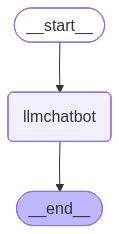

In [32]:
### Visualize the graph 
from IPython.display import Image,display

try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [33]:
response=graph.invoke({"messages":"Heelo how are you"})

In [34]:
response["messages"][-1].content


"Hello. I'm functioning properly, thank you for asking. How can I assist you today?"

In [35]:
for event in graph.stream({"messages":"Hello how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have. How can I assist you today?


### Chatbot with tool

In [36]:
from langchain_tavily import TavilySearch 

tool = TavilySearch(max_results=2)
tool.invoke("What is langgraph?")

{'query': 'What is langgraph?',
 'response_time': 0.63,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://huggingface.co/learn/agents-course/en/unit2/langgraph/when_to_use_langgraph',
   'title': 'What is LangGraph ? - Hugging Face Agents Course',
   'content': '# What is LangGraph ? `LangGraph` is a framework developed by LangChain **to manage the control flow of applications that integrate an LLM**. ## When should I use LangGraph ? `LangGraph` is on the other end of the spectrum, it shines when you need **“Control”** on the execution of your agent. LangGraph is particularly valuable when you need **Control over your applications**. It gives you the tools to build an application that follows a predictable process while still leveraging the power of LLMs. Put simply, if your application involves a series of steps that need to be orchestrated in a specific way, with decisions being made at each junction point, **LangGraph provides the structure 

In [37]:
## custom function 
def multiply(a:int,b:int) -> int:
    """ Multiply a and b
    Args:
        a (int): first number
        b (int): second number
    Returns:
        int: output int
    """
    return a*b

In [38]:
tools = [tool,multiply]

In [39]:
llm_with_tool = llm.bind_tools(tools)

In [40]:
llm_with_tool

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002938A3FB610>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002938A428050>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input sho

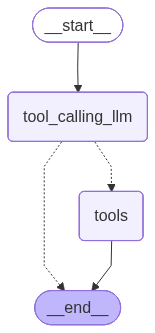

In [41]:
# state graph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition 

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]} 

## Graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edge 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message from the assistant is tool call -> tool condition routes to tool
    # If the latest message from the assistant is not tool call -> tool condition routes to END
    tools_condition
)

builder.add_edge("tools",END)

## compiler the graph 
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [42]:
response = graph.invoke({"messages":"What is the recent ai news"})

In [43]:
response["messages"][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.gamingonlinux.com/2026/01/gog-now-using-ai-generated-images-on-their-store/", "title": "GOG now using AI generated images on their store - GamingOnLinux", "score": 0.97821885, "published_date": "Wed, 28 Jan 2026 15:16:04 GMT", "content": "More recent related news is that they\'re even looking to bring GOG Galaxy to Linux (finally!) with a new job opening - that link is quite relevant here now too since it notes one of the responsibilities is to \\"Actively use and promote AI-assisted development tools\\", and so this news could further derail a lot of good-will for GOG from customers to game developers. A post on Reddit I spotted pointed out there seemed to be some AI generation on the GOG store page, and when you look at it properly - there\'s a lot of issues with it. When you\'re a smaller store, one that has clearly struggled in the past, this kind of cost-cutting

In [44]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (98cqqw51w)
 Call ID: 98cqqw51w
  Args:
    query: recent ai news
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.gamingonlinux.com/2026/01/gog-now-using-ai-generated-images-on-their-store/", "title": "GOG now using AI generated images on their store - GamingOnLinux", "score": 0.97821885, "published_date": "Wed, 28 Jan 2026 15:16:04 GMT", "content": "More recent related news is that they're even looking to bring GOG Galaxy to Linux (finally!) with a new job opening - that link is quite relevant here now too since it notes one of the responsibilities is to \"Actively use and promote AI-

In [45]:
response = graph.invoke({"messages":"What is 2 multiply by 3? "})

In [46]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiply by 3? 
================================== Ai Message ==================================
Tool Calls:
  multiply (ba92b3dww)
 Call ID: ba92b3dww
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


## REACT agent architecture 

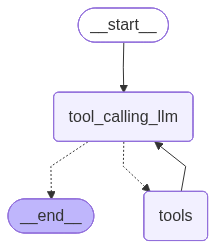

In [47]:
# state graph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]} 

## Graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edge 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message from the assistant is tool call -> tool condition routes to tool
    # If the latest message from the assistant is not tool call -> tool condition routes to END
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

## compiler the graph 
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [48]:
response = graph.invoke({"messages":"Give me recent AI news in brief and then multiply 5 by 6 "})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me recent AI news in brief and then multiply 5 by 6 
================================== Ai Message ==================================
Tool Calls:
  tavily_search (knpw7rcv2)
 Call ID: knpw7rcv2
  Args:
    query: recent AI news
    time_range: week
    topic: news
  multiply (gzfme9k43)
 Call ID: gzfme9k43
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.axios.com/2026/01/27/models-improve-ai", "title": "Models that improve on their own are AI's next big thing - Axios", "score": 0.67347145, "published_date": "Tue, 27 Jan 2026 09:00:04 GMT", "content": "AI models that can learn as they go are one of the hot new areas drawing interest from both startups and the leading labs, including Google DeepMind. **Why

### Adding memory to agentic AI

In [50]:
response = graph.invoke({"messages":"wHAT IS MY NAME? "})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

wHAT IS MY NAME? 
================================== Ai Message ==================================

I'm not aware of any information about your name.  I'm a large language model, I don't have the ability to know or recall personal information about individual users. If you'd like to share your name with me, I can use it in our conversation, but it won't be stored or retained.


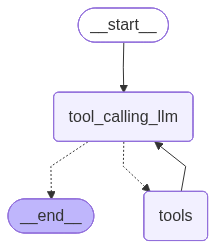

In [67]:
# state graph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 
from langgraph.checkpoint.memory import MemorySaver 

memory = MemorySaver()

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]} 

## Graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edge 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message from the assistant is tool call -> tool condition routes to tool
    # If the latest message from the assistant is not tool call -> tool condition routes to END
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

## compiler the graph 
graph = builder.compile(checkpointer = memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [68]:
config = {"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hello My name is aniket"},config = config)

# response
print(response["messages"][-1].content)

Hello, it's nice to meet you Aniket. How can I assist you today?


In [69]:

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello My name is aniket
================================== Ai Message ==================================

Hello, it's nice to meet you Aniket. How can I assist you today?


In [70]:

response = graph.invoke({"messages":"What is my name?"},config = config)

# for m in response["messages"]:
#     m.pretty_print()

print(response["messages"][-1].content)


Your name is Aniket.


## Streaming 

In [71]:
from langgraph.checkpoint.memory import MemorySaver 
memory = MemorySaver()

In [72]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

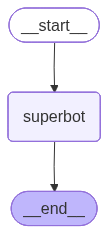

In [73]:
graph = StateGraph(State)

#node
graph.add_node("superbot", superbot)

#edge
graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

#compile
graph_builder = graph.compile(checkpointer=memory)

# Display 
from IPython.display import display, Image

#display the graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [78]:
### Invocation 

config = {"configurable":{"thread_id":"2"}}

graph_builder.invoke({"messages":"Hi, My name is Aniket and I live in Pune. "},config)

{'messages': [HumanMessage(content='Hi, My name is Aniket and I live in Pune. ', additional_kwargs={}, response_metadata={}, id='76617bc5-ae54-418f-a96e-c5e7fdcd2cbb'),
  AIMessage(content="Hello Aniket, it's nice to meet you. Pune is a beautiful city in India, known for its rich history, cultural heritage, and educational institutions. How are you doing today? What brings you here? Do you have any questions or topics you'd like to discuss? I'm all ears!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 50, 'total_tokens': 113, 'completion_time': 0.092542541, 'completion_tokens_details': None, 'prompt_time': 0.003034984, 'prompt_tokens_details': None, 'queue_time': 0.055760805, 'total_time': 0.095577525}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1d26-94c1-7841-a52d-b2dbb0418c84-0', tool_

In [76]:

print(response["messages"][-1].content)

Your name is Aniket.


Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.

updates : This streams updates to the state of the graph after each node is called.

In [ ]:
# Create a thread 
config = {"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":"Hi, My name is Aniket and I live in Pune. "},config,stream_mode="updates"):    print(chunk)

{'superbot': {'messages': [AIMessage(content="Nice to meet you, Aniket. Pune is a beautiful city in India, known for its rich history, cultural heritage, and educational institutions. What brings you here today? Do you have any specific questions or topics you'd like to discuss?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 50, 'total_tokens': 101, 'completion_time': 0.079707026, 'completion_tokens_details': None, 'prompt_time': 0.00751729, 'prompt_tokens_details': None, 'queue_time': 0.052378799, 'total_time': 0.087224316}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1d2a-129b-77d2-95d6-578be11a5763-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 50, 'output_tokens': 51, 'total_tokens': 101})]}}


In [82]:

for chunk in graph_builder.stream({"messages":"Hi, My name is Aniket and I like cricket. "},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Aniket and I live in Pune. ', additional_kwargs={}, response_metadata={}, id='1c62c8f6-cf24-4d57-8218-4696d77f4529'), AIMessage(content="Nice to meet you, Aniket. Pune is a beautiful city in India, known for its rich history, cultural heritage, and educational institutions. What brings you here today? Do you have any specific questions or topics you'd like to discuss?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 50, 'total_tokens': 101, 'completion_time': 0.079707026, 'completion_tokens_details': None, 'prompt_time': 0.00751729, 'prompt_tokens_details': None, 'queue_time': 0.052378799, 'total_time': 0.087224316}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1d2a-129b-77d2-95d6-578be11a5763-0', tool_calls=[], invalid_tool_calls=[], usage

In [83]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='Nice to meet you, Krish. Cricket is a fantastic sport with a huge following worldwide. Which team or player do you support? Are you a fan of international cricket, domestic leagues like the IPL, or local club cricket?\n\nAlso, do you have a favorite format of the game - Test matches, One-Day Internationals (ODIs), or Twenty20 Internationals (T20Is)?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 45, 'total_tokens': 126, 'completion_time': 0.128749733, 'completion_tokens_details': None, 'prompt_time': 0.00374968, 'prompt_tokens_details': None, 'queue_time': 0.050305467, 'total_time': 0.132499413}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1d32-5f26-7e53-a6cc-847cf118d45a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens

In [86]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='d6b43abc-4751-48fb-b000-5e3bf2702ac1'), AIMessage(content='Nice to meet you, Krish. Cricket is a fantastic sport with a huge following worldwide. Which team or player do you support? Are you a fan of international cricket, domestic leagues like the IPL, or local club cricket?\n\nAlso, do you have a favorite format of the game - Test matches, One-Day Internationals (ODIs), or Twenty20 Internationals (T20Is)?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 45, 'total_tokens': 126, 'completion_time': 0.128749733, 'completion_tokens_details': None, 'prompt_time': 0.00374968, 'prompt_tokens_details': None, 'queue_time': 0.050305467, 'total_time': 0.132499413}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_pr